In [19]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold
from sklearn.datasets import fetch_openml

%matplotlib inline

# Load the data

In [20]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.to_numpy()
y = mnist.target.to_numpy()

y = y.astype(np.int64)
X = np.array([np.array(x) for x in X], dtype="int64")
N, D = X.shape

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"X dtype: {X_train.dtype}, y dtype: {y_train.dtype}")
print(f"Training data: {X_train.shape}, Training labels: {y_train.shape}")
print(f"Testing data: {X_test.shape}, Testing labels: {y_test.shape}")

X dtype: int64, y dtype: int64
Training data: (60000, 784), Training labels: (60000,)
Testing data: (10000, 784), Testing labels: (10000,)


In [21]:
# Optional: use a smaller sample of the data
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y_test == c)[0], size=10, replace=False))
Xtest_s = X_test[p, :]
ytest_s = y_test[p]
Ntest_s = Xtest_s.shape[0]

In [22]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")
    plt.show()

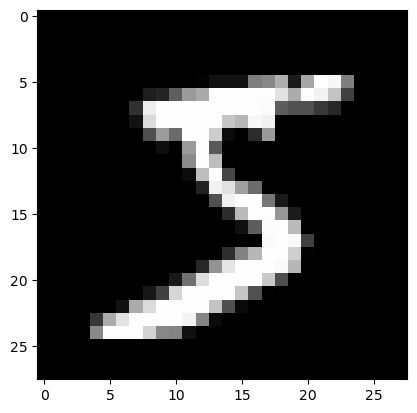

5


In [23]:
# Example: show first digit
showdigit(X[0,])
print(y[0])

In [24]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(np.bincount(y)))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

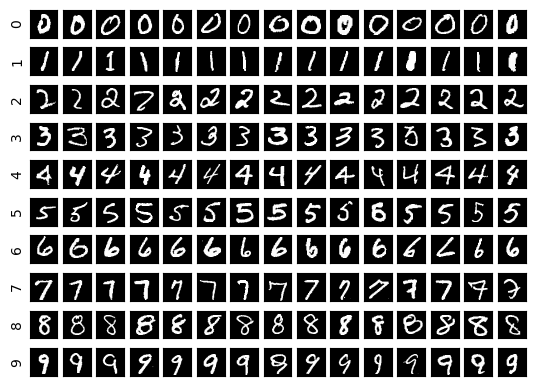

In [25]:
# Example: show 15 random digits per class from training data
showdigits(X, y)

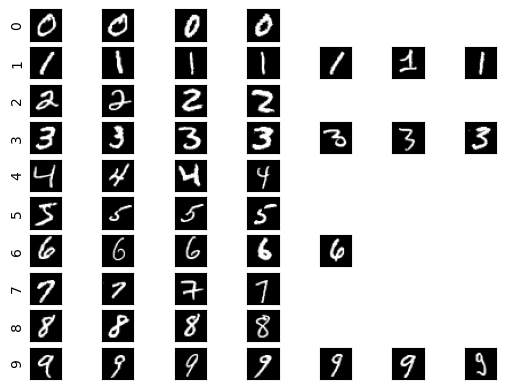

In [26]:
# Example: show a specific set of digits
showdigits(X[0:50,], y[0:50])

In [27]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

# 1 Training

In [28]:
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """
    N, D = X.shape
    if K is None:
        K = np.max(X) + 1
    if C is None:
        C = np.max(y) + 1

    # Compute class priors and store them in priors
    priors = np.zeros(C, dtype=np.float64)
    counts = np.zeros(C, dtype=np.int64)
    
    # count unique values
    digits, class_counts = np.unique(y, return_counts=True)
    class_counts = class_counts.astype(np.int64)
    counts[digits] = class_counts

    # for all digits calculate prior using count + alpha / N + (alpha * c)
    for c in range(C):
        priors[c] = (float(counts[c]) + alpha) / (N + alpha * C)
        
    # Compute class-conditional densities in a class x feature x value array
    # and store them in cls.
    cls = np.zeros((C, D, K), dtype=np.float64)
    
    for c in range(C):
        for j in range(D):
            values, feature_counts = np.unique(X[y == c, j], return_counts=True)    # select all rows where y == c, count unique values of columns
            feature_counts = feature_counts.astype(np.int64)
            values_count_arr = np.zeros(K, dtype=np.int64)
            values_count_arr[values] = feature_counts

            # jetzt haben wir die Anzahl an unique values (0, 1, ..., 255) pro Klasse pro feature
            cls[c, j, :] = (values_count_arr + alpha) / (counts[c] + alpha * K)

    # Output result
    return dict(logpriors=np.log(priors), logcls=np.log(cls))

In [29]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

In [30]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logpriors': array([-0.91629073, -1.2039728 , -1.2039728 ]),
 'logcls': array([[[-1.38629436, -0.98082925, -0.98082925],
         [-0.69314718, -1.38629436, -1.38629436]],
 
        [[-0.84729786, -1.25276297, -1.25276297],
         [-1.25276297, -0.84729786, -1.25276297]],
 
        [[-1.25276297, -0.84729786, -1.25276297],
         [-1.25276297, -0.84729786, -1.25276297]]])}

# 2 Prediction

In [31]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [32]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))
    
    for n in range(Nnew):
        for c in range(C):
            logjoint[n, c] = logpriors[c]  # Start with log prior
            for j in range(D):  # Loop over features
                v = Xnew[n, j]  # Feature value of test point n at feature j
                logjoint[n, c] += logcls[c, j, v]  # Add log likelihood

    yhat = np.argmax(logjoint, axis=1) # return the indicies of the max log posterior for each x_i

    logprob = np.max(logjoint, axis=1)

    return dict(yhat=yhat, logprob=logprob)

In [33]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0, 1, 2, 0]),
 'logprob': array([-2.59026717, -2.89856853, -2.89856853, -2.59026717])}

# 3 Experiments on MNIST Digits Data

In [34]:
# Let's train the model on the digits data and predict
model_nb2 = nb_train(X_train, y_train, alpha=2)
pred_nb2 = nb_predict(model_nb2, X_test)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [35]:
# Accuracy
sklearn.metrics.accuracy_score(y_test, yhat)

0.8285

Text(0.5, 0.98, 'Digits grouped by predicted label')

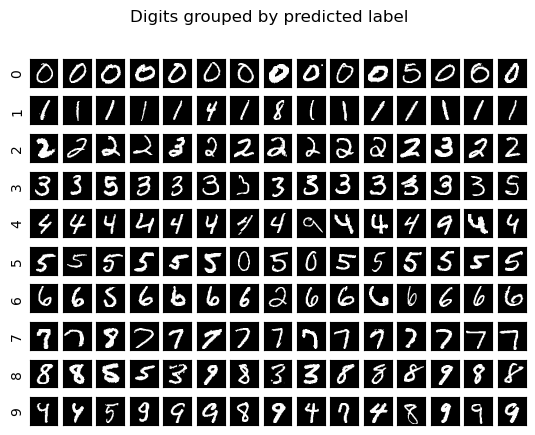

In [36]:
# show some digits grouped by prediction; can you spot errors?
showdigits(X_test, yhat)
plt.suptitle("Digits grouped by predicted label")

Text(0.5, 0.98, 'Errors grouped by predicted label')

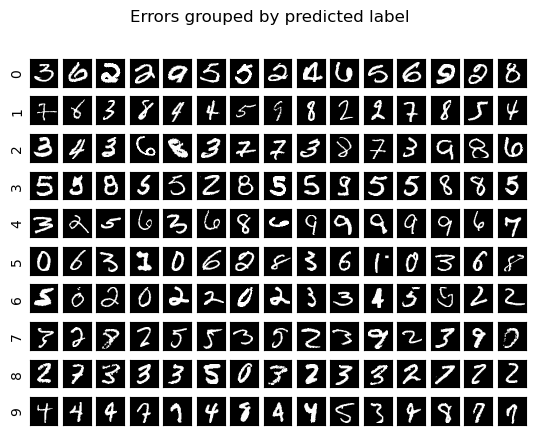

In [37]:
# do the same, but this time show wrong predicitions only
perror = y_test != yhat
showdigits(X_test[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

Text(0.5, 0.98, 'Errors grouped by predicted label')

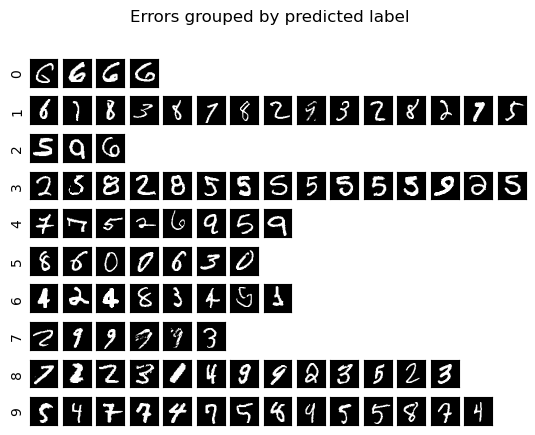

In [38]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
showdigits(X_test[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

In [39]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(y_test, yhat))
print(sklearn.metrics.confusion_matrix(y_test, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       980
           1       0.80      0.99      0.88      1135
           2       0.90      0.77      0.83      1032
           3       0.75      0.83      0.79      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.61      0.69       892
           6       0.88      0.89      0.89       958
           7       0.90      0.85      0.87      1028
           8       0.83      0.76      0.79       974
           9       0.75      0.84      0.80      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.83      0.83     10000

[[ 867    0    3    9    5   61   21    1   12    1]
 [   0 1118    3    2    0    3    3    0    6    0]
 [  15   52  795   38   28    7   33   20   40    4]
 [   4   26   28  839    2   27    9   14   39   22]
 [   1   17    5    1  808   

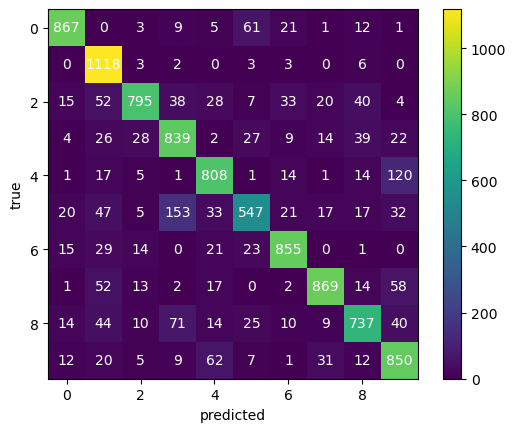

In [40]:
# plot the confusion matrix
M = sklearn.metrics.confusion_matrix(y_test, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


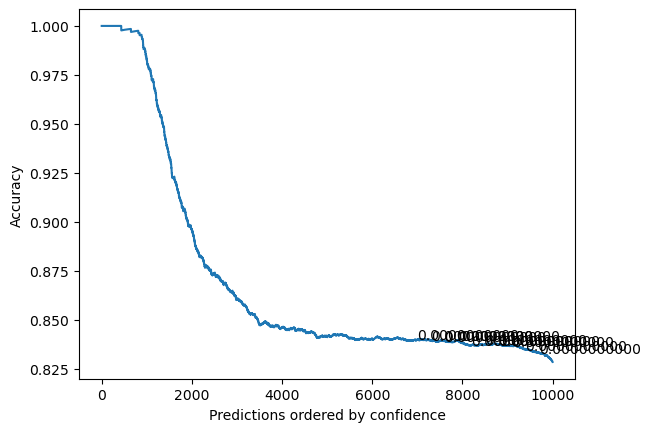

In [41]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(y_test[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

Text(0, 0.5, 'Accuracy')

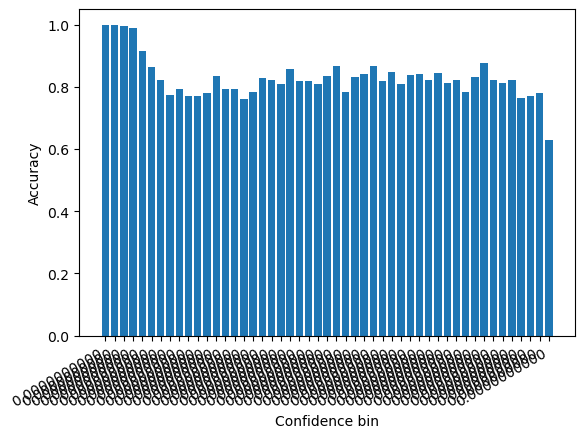

In [42]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(y_test[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [43]:
# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True)
for i_train, i_test in Kf.split(X):
    # code here is executed K times, once per test fold
    # i_train has the row indexes of X to be used for training
    # i_test has the row indexes of X to be used for testing
    print(
        "Fold has {:d} training points and {:d} test points".format(
            len(i_train), len(i_test)
        )
    )

Fold has 56000 training points and 14000 test points
Fold has 56000 training points and 14000 test points
Fold has 56000 training points and 14000 test points
Fold has 56000 training points and 14000 test points
Fold has 56000 training points and 14000 test points


In [44]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.
# YOUR CODE HERE

# 5 Generating Data

In [49]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        for j in range(D):
            # Exponentiate log probabilities to get probabilities for feature j
            theta = np.exp(logcls[c, j, :])
            theta /= np.sum(theta)  # Normalize to ensure sum of probabilities = 1

            # Sample a value for feature j from the categorical distribution
            Xgen[i, j] = np.random.choice(range(K), p=theta)

    return Xgen

Text(0.5, 0.98, 'Some generated digits for each class')

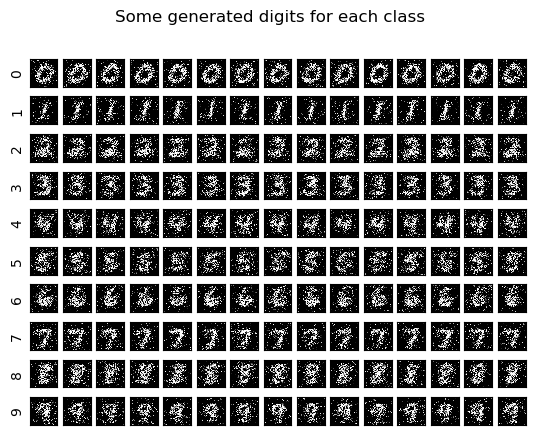

In [50]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

Text(0.5, 0.98, 'Most likely value of each feature per class')

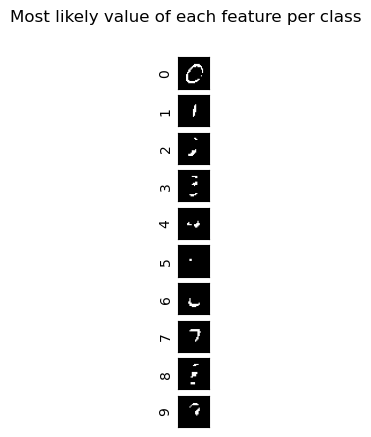

In [51]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

Text(0.5, 0.98, 'Expected value of each feature per class')

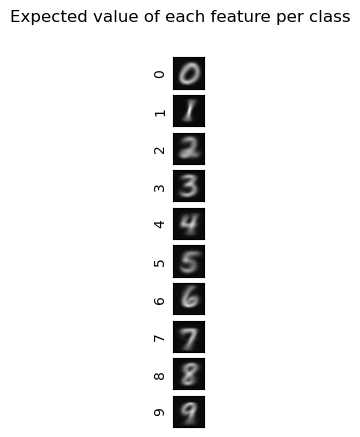

In [52]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")